### My Undertstanding of the Problem:
#### In this dataset, each row represents the purchase of one unit of a certain product combination, with attributes listed in columns A, B, C, D, E, and F. Multiple rows in the training set, which runs from July 2020 to May 2021, may have the same product combination, indicating recurring sourcing incidents. Essentially, each row represents the purchase of a single unit of a certain product combination. In June 2021, the test set will contain only one value for each combination, acting as the forecasting objective. This configuration allows for the creation of a predictive model trained on the 11-month dataset to project the sourcing amount for June 2021 using the training data's observed patterns and trends.


### Expectations
#### 
- Utilize machine learning (ML) models to predict the sourcing quantity for June 2021.
- Use the training set data spanning from July 2020 to May 2021 to train the models.
- Experiment with various ML algorithms iteratively.
- Fine-tune the parameters of the ML algorithms.
- Potentially employ feature engineering techniques to enhance model performance.
- Aim to develop a model that closely aligns with the test set data, specifically the sourcing quantities recorded for June 2021.
- Minimize the disparity between the predicted values and the actual test set data.
- Select the most suitable ML model that best captures the underlying patterns in the training data and generalizes well to make accurate predictions for the test set.

### Importing Libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import  LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency
from sklearn.model_selection import  train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor

### Loading the Data

In [2]:
# Load your train and test datasets
test_df = pd.read_csv(r"Data\test_dataset.csv")
train_df = pd.read_csv(r"Data\training_dataset.csv")


In [3]:
test_df

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
0,NTM1,X1,A1,DIRECT,Small,Powder,Jun-21,103.68
1,NTM1,X1,A10,DIRECT,Large,Powder,Jun-21,155.75
2,NTM1,X1,A10,ECOM,Large,Powder,Jun-21,143.02
3,NTM1,X1,A11,DIRECT,Large,Powder,Jun-21,139.39
4,NTM1,X1,A2,DIRECT,Large,Powder,Jun-21,169.42
...,...,...,...,...,...,...,...,...
91,NTM3,X1,A44,DIRECT,Small,Liquid,Jun-21,89.57
92,NTM3,X1,A8,DIRECT,Large,Powder,Jun-21,114.57
93,NTM3,X1,A8,DIRECT,Small,Powder,Jun-21,111.26
94,NTM3,X2,A20,DIRECT,Large,Powder,Jun-21,32.32


### Splitting Month of Sourcing into seperate columns month and year
#### why?
- Splitting the 'Month of Sourcing' column into 'Month' and 'Year' allows for:
- Data transformation to numeric format, essential for many ML algorithms.
- Potential feature engineering, enabling the creation of additional time-based features.
- Facilitation of temporal analysis, aiding in detecting trends and patterns over time.
- Improved model interpretability, as it helps explain sourcing behavior in terms of months and years.
----------------------------------------------------------------------------------------------------
#### Explaination of Code
- The first part of the code defines a dictionary month_to_num, which maps month abbreviations to numeric values. Next, assuming that the 'Month of Sourcing' column contains dates in the format 'Jun-21', the code splits this column into two separate columns: 'Month' and 'Year'. This is done using the str.split() method with the '-' delimiter, and expand=True to expand the result into separate columns. After splitting, the month abbreviations ('Jun', 'Jul', etc.) are mapped to their corresponding numeric values using the map() function and the month_to_num dictionary.
- The next step converts the 'Year' column from string to numeric type using the pd.to_numeric() function. The errors='coerce' parameter handles any errors by converting them to NaN (Not a Number).Finally, the 'Month of Sourcing' column is dropped from both the train and test DataFrames using the drop() method with columns=['Month of Sourcing']. This column is no longer needed since the month and year have been split into separate columns.The result is then displayed to verify that the 'Month' and 'Year' columns have been correctly extracted and mapped to numeric values.

In [4]:
# Mapping of month abbreviations to numeric values
month_to_num = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

# Assuming 'Month of Sourcing' column contains dates in the format 'Jun-21'

# Split 'Month of Sourcing' into 'Month' and 'Year' columns
test_df[['Month', 'Year']] = test_df['Month of Sourcing'].str.split('-', expand=True)

train_df[['Month', 'Year']] = train_df['Month of Sourcing'].str.split('-', expand=True)

# Map month abbreviations to numeric values
test_df['Month'] = test_df['Month'].map(month_to_num)

train_df['Month'] = train_df['Month'].map(month_to_num)
# Convert 'Year' column to numeric type
test_df['Year'] = pd.to_numeric(test_df['Year'], errors='coerce')

train_df['Year'] = pd.to_numeric(train_df['Year'], errors='coerce')

# Dropping month of sourcing columns
train_df.drop(columns=['Month of Sourcing'], inplace=True)
test_df.drop(columns=['Month of Sourcing'], inplace=True)

# Display the first few rows to verify the result
print(test_df[['Month', 'Year']].head())
print(train_df[['Month', 'Year']].head())


   Month  Year
0      6    21
1      6    21
2      6    21
3      6    21
4      6    21
   Month  Year
0      5    21
1     10    20
2     12    20
3      2    21
4     11    20


## Separating Prefix and Suffix From Column
- Enhanced Understanding: It helps clarify the structure and meaning of the data.
- Feature Engineering: Allows for the creation of new features based on these components.
- Standardization: Ensures consistency and compatibility across systems.
- Improved Model Performance: Provides additional information for more effective modeling.
- Flexibility: Enables independent operations on each component for versatile data manipulation.

## 1. Separating prefix and suffix ProductType
- The first two lines extract the prefix and ID from the 'ProductType' column in the train DataFrame.
- train_df['ProductType'].str[:-1] slices the string in each row of the 'ProductType' column, leaving out the last character (which is assumed to be the ID).
- train_df['ProductType'].str[-1:] slices the string in each row of the 'ProductType' column, taking only the last character (which is assumed to be the ID).
- Similarly, the next two lines extract the prefix and ID from the 'ProductType' column in the test DataFrame.
- After extracting the prefix and ID, the prefix columns are dropped from both the train and test DataFrames using the drop() method with columns=['ProductType_prefix']. This is done because the prefix may not be relevant for modeling purposes.
- Next, the original 'ProductType' column is dropped from both DataFrames using the same method. This is because the information from the 'ProductType' column has been split into 'ProductType_prefix' and 'ProductType_id', and the original column is no longer needed

In [5]:
train_df['ProductType_prefix'] = train_df['ProductType'].str[:-1]
train_df['ProductType_id'] = train_df['ProductType'].str[-1:]

test_df['ProductType_prefix'] = test_df['ProductType'].str[:-1]
test_df['ProductType_id'] = test_df['ProductType'].str[-1:]

# Dropping prefix columns
train_df.drop(columns=['ProductType_prefix'], inplace=True)
test_df.drop(columns=['ProductType_prefix'], inplace=True)

train_df.drop(columns=['ProductType'], inplace=True)
test_df.drop(columns=['ProductType'], inplace=True)

## 2. Separating prefix and suffix Manufacturer
- The first two lines of code extract the Manufacturer prefix and ID from the 'Manufacturer' column in both the train and test DataFrames.
- str[:-1] extracts all characters of the 'Manufacturer' column except the last one, representing the Manufacturer prefix.
- str[-1:] extracts only the last character of the 'Manufacturer' column, representing the Manufacturer ID.
- The next two lines drop the 'Manufacturer_prefix' column from both train and test DataFrames. Since we've already extracted the prefix and ID, we no longer need this intermediate column.
- Similarly, the last two lines drop the original 'Manufacturer' column from both DataFrames, as we have extracted the relevant information into separate columns.


In [6]:
train_df['Manufacturer_prefix'] = train_df['Manufacturer'].str[:-1]
train_df['Manufacturer_id'] = train_df['Manufacturer'].str[-1:]

test_df['Manufacturer_prefix'] = test_df['Manufacturer'].str[:-1]
test_df['Manufacturer_id'] = test_df['Manufacturer'].str[-1:]

# Dropping  columns
train_df.drop(columns=['Manufacturer_prefix'], inplace=True)
test_df.drop(columns=['Manufacturer_prefix'], inplace=True)

train_df.drop(columns=['Manufacturer'], inplace=True)
test_df.drop(columns=['Manufacturer'], inplace=True)

In [7]:
train_df

,Area Code,Sourcing Channel,Product Size,Product Type,Sourcing Cost,Month,Year,ProductType_id,Manufacturer_id
0,A28,WHOLESALE,Large,Powder,10.16,5,21,3,1
1,A9,DIRECT,Large,Powder,134.28,10,20,2,1
2,A20,DIRECT,Large,Powder,12.46,12,20,3,2
3,A18,WHOLESALE,Small,Powder,107.22,2,21,3,1
4,A28,DIRECT,Large,Liquid,197.76,11,20,2,1
...,...,...,...,...,...,...,...,...,...
550171,A5,DIRECT,Large,Powder,136.47,7,20,2,1
550172,A14,DIRECT,Large,Liquid,72.56,10,20,3,1
550173,A5,DIRECT,Small,Powder,147.64,3,21,2,1
550174,A7,DIRECT,Small,Powder,150.04,2,21,2,1


## 3.  Separating prefix and suffix Area Code
- The first part of the code uses regular expressions (regex) to extract the prefix and suffix from the 'Area Code' column in both train_df and test_df.
- In the regex pattern r'([A-Za-z]+)(\d+)', ([A-Za-z]+) captures one or more alphabetical characters (prefix), and (\d+) captures one or more numeric digits (suffix).
- The str.extract() method extracts the prefix and suffix into separate columns ('Area Code_prefix' and 'Area Code_id') in both DataFrames.
- Next, the code drops the 'Area Code_prefix' column from both DataFrames, as it is no longer needed.
- Similarly, the 'Area Code' column is dropped from both DataFrames, as the prefix and suffix have been extracted and stored separately.
- This preprocessing step is necessary to split the 'Area Code' column into more meaningful components, which can potentially provide additional information for the machine learning model

In [8]:
# Extracting prefix and suffix using regular expressions
train_df[['Area Code_prefix', 'Area Code_id']] = train_df['Area Code'].str.extract(r'([A-Za-z]+)(\d+)')
test_df[['Area Code_prefix', 'Area Code_id']] = test_df['Area Code'].str.extract(r'([A-Za-z]+)(\d+)')

# Dropping columns
train_df.drop(columns=['Area Code_prefix'], inplace=True)
test_df.drop(columns=['Area Code_prefix'], inplace=True)

train_df.drop(columns=['Area Code'], inplace=True)
test_df.drop(columns=['Area Code'], inplace=True)


## Converting to Int16 format

In [9]:
train_df['Manufacturer_id'] = train_df['Manufacturer_id'].astype('Int16')
train_df['ProductType_id'] = train_df['ProductType_id'].astype('Int16')
train_df['Area Code_id'] = train_df['Area Code_id'].astype('Int16')
train_df['Month'] = train_df['Month'].astype('Int16')
train_df['Year'] = train_df['Year'].astype('Int16')

test_df['Manufacturer_id'] = test_df['Manufacturer_id'].astype('Int16')
test_df['ProductType_id'] = test_df['ProductType_id'].astype('Int16')
test_df['Area Code_id'] = test_df['Area Code_id'].astype('Int16')
test_df['Month'] = test_df['Month'].astype('Int16')
test_df['Year'] = test_df['Year'].astype('Int16')
# Checking data types after conversion
print("\nAfter conversion:")
print(test_df.dtypes)


After conversion:
Sourcing Channel     object
Product Size         object
Product Type         object
Sourcing Cost       float64
Month                 Int16
Year                  Int16
ProductType_id        Int16
Manufacturer_id       Int16
Area Code_id          Int16
dtype: object


## Label Encoding
### Why?
- Simplicity: Converts categorical data into numeric labels, facilitating easier processing by machine learning algorithms.
- Memory Efficiency: Reduces memory usage compared to one-hot encoding, especially for datasets with many categorical variables.
- Preserves Order: Preserves ordinal information in ordinal categorical variables, aiding algorithms that can leverage such information.
- Feature Space Reduction: Reduces the dimensionality of the feature space, potentially improving model performance and training efficiency.
- Ease of Interpretation: Simplifies interpretation for humans and algorithms by providing a straightforward numeric representation of categories.

In [10]:
# Initialize LabelEncoder with handle_unknown='ignore'
label_encoder = LabelEncoder()

# Fit and transform the 'Product Size' column in train_df
train_df['Product Size'] = label_encoder.fit_transform(train_df['Product Size'])

# Transform the 'Product Size' column in test_df using the same label encoder
test_df['Product Size'] = label_encoder.transform(test_df['Product Size'])

## One Hot Encoding
- One-hot encoding was performed on the 'Sourcing Channel' and 'Product Type' columns to convert categorical variables into a numerical format suitable for machine learning algorithms. This technique creates binary indicator variables for each category within the original categorical variables.

- Sourcing Channel: If there are, for example, three different sourcing channels ('Online', 'Offline', 'Direct'), one-hot encoding creates three binary columns. Each row is represented by a 1 in the column corresponding to the sourcing channel used and 0s in the other columns.

- Product Type: Similarly, if there are multiple product types ('A', 'B', 'C'), one-hot encoding creates a binary column for each product type.

This transformation ensures that the algorithm treats each category as independent and avoids imposing any ordinality or false assumptions about the numerical relationship between categories. It allows the algorithm to effectively learn from categorical data and make accurate predictions.

In [12]:
# Perform one-hot encoding on 'Sourcing Channel' and 'Product Type' columns in train_df
train_df = pd.get_dummies(train_df, columns=['Sourcing Channel', 'Product Type'])

# Perform one-hot encoding on 'Sourcing Channel' and 'Product Type' columns in test_df
test_df = pd.get_dummies(test_df, columns=['Sourcing Channel', 'Product Type'])

# Convert boolean values to 0 and 1
train_df = train_df.astype(int)
test_df = test_df.astype(int)

print(train_df)
print(test_df)

        Product Size  Sourcing Cost  Month  Year  ProductType_id  \
0                  1             10      5    21               3   
1                  1            134     10    20               2   
2                  1             12     12    20               3   
3                  2            107      2    21               3   
4                  1            197     11    20               2   
...              ...            ...    ...   ...             ...   
550171             1            136      7    20               2   
550172             1             72     10    20               3   
550173             2            147      3    21               2   
550174             2            150      2    21               2   
550175             2            139     11    20               1   

        Manufacturer_id  Area Code_id  Sourcing Channel_DIRECT  \
0                     1            28                        0   
1                     1             9              

## EDA

## Correlation between Target: Sourcing Cost and Input

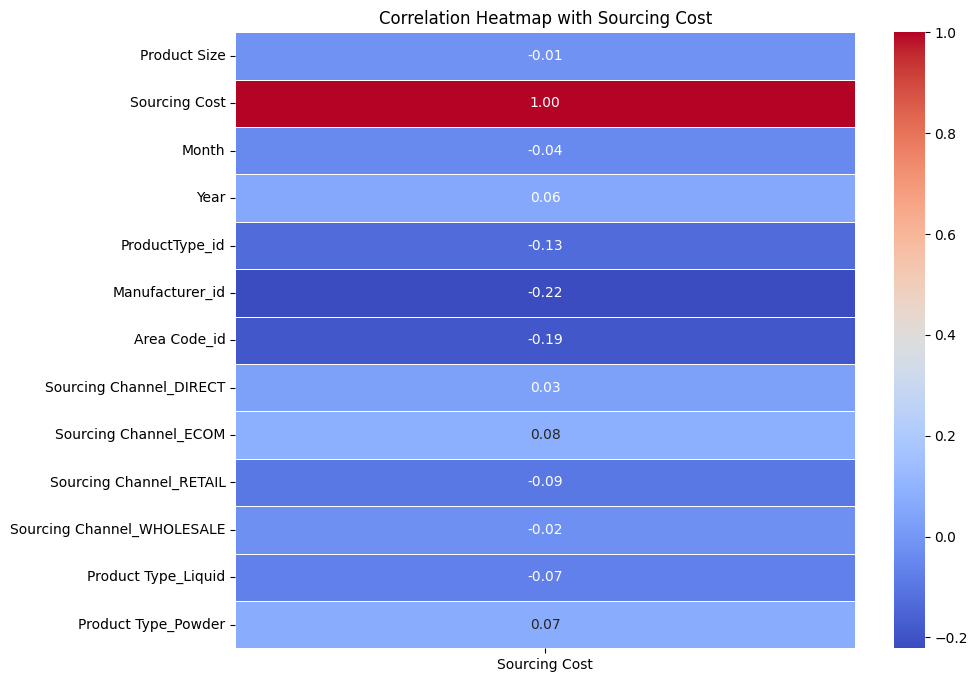

The column with the highest correlation with 'Sourcing Cost' is 'Sourcing Channel_ECOM' with a correlation coefficient of 0.08.


In [13]:

# Concatenate train_df and test_df
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Calculate correlation matrix
correlation_matrix = combined_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[['Sourcing Cost']], annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap with Sourcing Cost')
plt.show()

# Find column with highest correlation with 'Sourcing Cost'
highest_correlation = correlation_matrix['Sourcing Cost'].drop('Sourcing Cost').idxmax()
highest_correlation_value = correlation_matrix['Sourcing Cost'].drop('Sourcing Cost').max()
print(f"The column with the highest correlation with 'Sourcing Cost' is '{highest_correlation}' with a correlation coefficient of {highest_correlation_value:.2f}.")


## Correlation between Input Variables

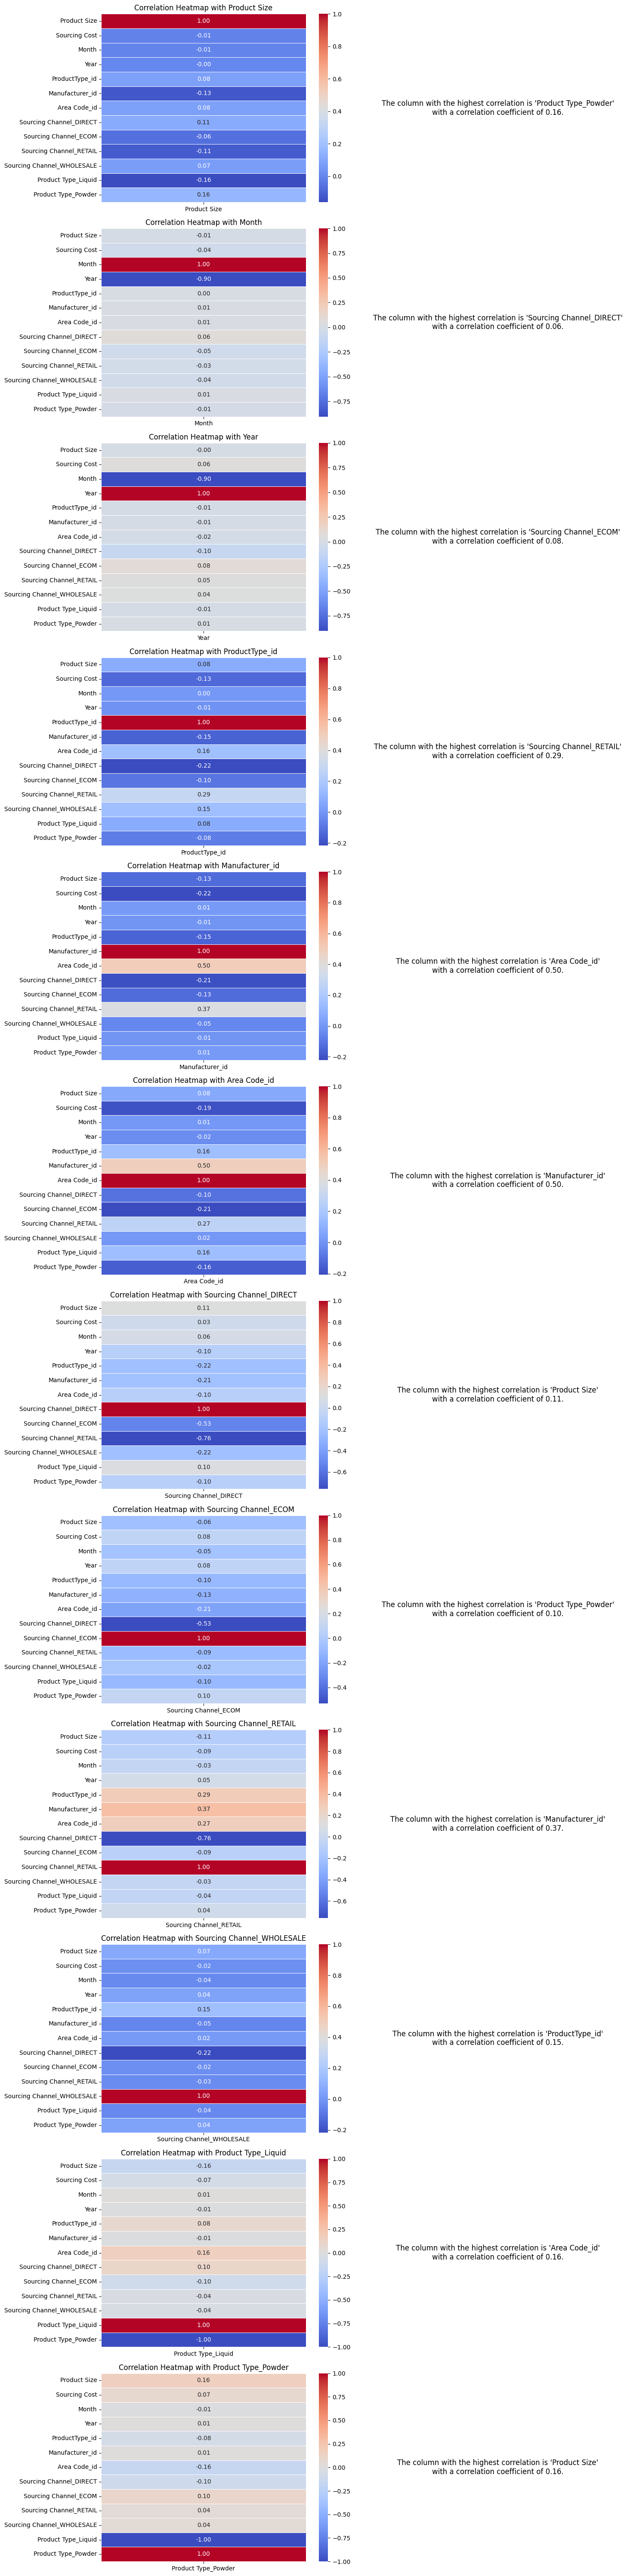

In [14]:
# Get all input variables except 'Sourcing Cost'
input_variables = train_df.columns[train_df.columns != 'Sourcing Cost']

# Create subplots
num_plots = len(input_variables)
fig, axes = plt.subplots(num_plots, 2, figsize=(15, 5*num_plots))

# Iterate through each input variable
for i, column in enumerate(input_variables):
    # Calculate correlation matrix
    correlation_matrix = train_df.corr()

    # Plot heatmap
    sns.heatmap(correlation_matrix[[column]], annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, ax=axes[i][0])
    axes[i][0].set_title(f'Correlation Heatmap with {column}')

    # Find column with highest correlation with the current input variable
    highest_correlation = correlation_matrix[column].drop(column).idxmax()
    highest_correlation_value = correlation_matrix[column].drop(column).max()
    axes[i][1].text(0.5, 0.5, f"The column with the highest correlation is '{highest_correlation}'\nwith a correlation coefficient of {highest_correlation_value:.2f}.", 
                    horizontalalignment='center', verticalalignment='center', fontsize=12)
    axes[i][1].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

## VIF
- VIF (Variance Inflation Factor) is used to assess multicollinearity among predictor variables in a regression analysis. It quantifies how much the variance of an estimated regression coefficient is inflated due to multicollinearity in the model.

- Purpose: We calculate VIF to identify if there are high levels of multicollinearity among the predictor variables in the dataset after dropping certain columns. High VIF values indicate that the predictor variables are highly correlated with each other, which can lead to unstable estimates of the coefficients and difficulty in interpreting the model.
- Interpretation: Generally, a VIF value exceeding 10 is considered problematic and suggests multicollinearity. Lower VIF values indicate lower levels of multicollinearity and are preferable.
- Use in Model Building: By assessing VIF, we can decide whether to exclude certain predictor variables from the model to mitigate multicollinearity issues. Dropping highly correlated variables can lead to a more stable and interpretable model.

-------------------------------------------------------------------------------------------------------
The VIF results indicate the level of multicollinearity among predictor variables:

- Product Size: Moderately correlated with other predictors.
- Sourcing Cost: Unusual result, needs further investigation.
- Month: Moderately correlated with other predictors.
- Year: Highly correlated with other predictors.
- ProductType_id: Moderately correlated with other predictors.
- Manufacturer_id: Moderately to highly correlated with other predictors.
- Area Code_id: Moderately correlated with other predictors.

High VIF values for 'Year' and 'Manufacturer_id' suggest strong correlation with other predictors, potentially indicating redundancy. Further investigation and remedial actions may be needed.

In [15]:
# Drop the specified columns from train_df
columns_to_exclude = ['Sourcing Channel_DIRECT', 'Sourcing Channel_ECOM', 'Sourcing Channel_RETAIL', 
                      'Sourcing Channel_WHOLESALE', 'Product Type_Liquid', 'Product Type_Powder']
X_train_filtered = train_df.drop(columns=columns_to_exclude)

# Calculate VIF for the remaining variables
vif_train_filtered = pd.DataFrame()
vif_train_filtered["Variable"] = X_train_filtered.columns
vif_train_filtered["VIF"] = [variance_inflation_factor(X_train_filtered.values, i) for i in range(X_train_filtered.shape[1])]

# Display results
print("VIF for train_df excluding specified columns:")
print(vif_train_filtered)

VIF for train_df excluding specified columns:
          Variable        VIF
0     Product Size   9.041190
1    Sourcing Cost  -0.079006
2            Month   3.862690
3             Year  32.917723
4   ProductType_id   8.273530
5  Manufacturer_id  12.367038
6     Area Code_id   4.456102


#### VIF is calculated after dropping specified columns from `test_df` to ensure that multicollinearity is not present among the remaining predictor variables. If high VIF values are detected, further actions such as additional variable exclusion or transformation may be required to address multicollinearity and improve model performance.
-----------------------------------------------------------------------------------------
The VIF results indicate the level of multicollinearity among predictor variables after excluding specified columns:

- Product Size: Moderately correlated with other predictors.
- Sourcing Cost: Unusual result, needs further investigation.
- Month: Moderately correlated with other predictors.
- Year: Highly correlated with other predictors.
- ProductType_id: Moderately correlated with other predictors.
- Manufacturer_id: Moderately to highly correlated with other predictors.
- Area Code_id: Moderately correlated with other predictors.

High VIF values for 'Year' and 'Manufacturer_id' suggest strong correlation with other predictors, potentially indicating redundancy. Further investigation and remedial actions may be needed.

In [16]:
# Drop the specified columns from test_df
columns_to_exclude = ['Sourcing Channel_DIRECT', 'Sourcing Channel_ECOM', 'Sourcing Channel_RETAIL', 
                      'Sourcing Channel_WHOLESALE', 'Product Type_Liquid', 'Product Type_Powder']
X_test_filtered = train_df.drop(columns=columns_to_exclude)

# Calculate VIF for the remaining variables
vif_test_filtered = pd.DataFrame()
vif_test_filtered["Variable"] = X_test_filtered.columns
vif_test_filtered["VIF"] = [variance_inflation_factor(X_test_filtered.values, i) for i in range(X_test_filtered.shape[1])]

# Display results
print("VIF for train_df excluding specified columns:")
print(vif_test_filtered)

VIF for train_df excluding specified columns:
          Variable        VIF
0     Product Size   9.041190
1    Sourcing Cost  -0.079006
2            Month   3.862690
3             Year  32.917723
4   ProductType_id   8.273530
5  Manufacturer_id  12.367038
6     Area Code_id   4.456102


### Chi Square Test
#### The chi-square test is used to determine if there is a significant association between two categorical variables. In this case, we're performing the chi-square test to assess the relationship between each specified categorical column (e.g., 'Sourcing Channel', 'Product Type') and the numerical 'Sourcing Cost'.
--------------------------------------------------
Results
These results suggest that both 'Sourcing Channel' and 'Product Type' are likely to be important predictors of the 'Sourcing Cost', and including them in the model may improve its predictive performance.

In [17]:
# Specify the columns to perform the chi-square test on
columns_to_test = ['Sourcing Channel_DIRECT', 'Sourcing Channel_ECOM', 'Sourcing Channel_RETAIL', 
                   'Sourcing Channel_WHOLESALE', 'Product Type_Liquid', 'Product Type_Powder']

# Perform chi-square test for each specified column
for column in columns_to_test:
    contingency_table = pd.crosstab(train_df[column], train_df['Sourcing Cost'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"Chi-square test for {column}:")
    print(f"Chi-square statistic: {chi2}")
    print(f"P-value: {p}")
    print("")

Chi-square test for Sourcing Channel_DIRECT:
Chi-square statistic: 127061.62444914518
P-value: 0.0

Chi-square test for Sourcing Channel_ECOM:
Chi-square statistic: 76698.42006002579
P-value: 0.0

Chi-square test for Sourcing Channel_RETAIL:
Chi-square statistic: 194474.4235983947
P-value: 0.0

Chi-square test for Sourcing Channel_WHOLESALE:
Chi-square statistic: 136785.75469126587
P-value: 0.0

Chi-square test for Product Type_Liquid:
Chi-square statistic: 159586.30618564648
P-value: 0.0

Chi-square test for Product Type_Powder:
Chi-square statistic: 159586.30618564645
P-value: 0.0



In [18]:
# Specify the columns to perform the chi-square test on
columns_to_test = ['Sourcing Channel_DIRECT', 'Sourcing Channel_ECOM', 'Sourcing Channel_RETAIL', 
                   'Sourcing Channel_WHOLESALE', 'Product Type_Liquid', 'Product Type_Powder']

# Perform chi-square test for each specified column
for column in columns_to_test:
    contingency_table = pd.crosstab(test_df[column], test_df['Sourcing Cost'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"Chi-square test for {column}:")
    print(f"Chi-square statistic: {chi2}")
    print(f"P-value: {p}")
    print("")

Chi-square test for Sourcing Channel_DIRECT:
Chi-square statistic: 70.90478873239437
P-value: 0.41397232946178214

Chi-square test for Sourcing Channel_ECOM:
Chi-square statistic: 68.53639846743295
P-value: 0.49311136251886983

Chi-square test for Sourcing Channel_RETAIL:
Chi-square statistic: 74.64689527340133
P-value: 0.29993480314514953

Chi-square test for Sourcing Channel_WHOLESALE:
Chi-square statistic: 96.0
P-value: 0.017525277273293498

Chi-square test for Product Type_Liquid:
Chi-square statistic: 71.71282051282051
P-value: 0.38798368886923906

Chi-square test for Product Type_Powder:
Chi-square statistic: 71.71282051282053
P-value: 0.3879836888692386



## Kfold
K-fold cross-validation is used to assess the performance of a model by splitting the data into 'k' equal-sized folds and iteratively training the model on 'k-1' folds while validating it on the remaining fold. This process is repeated 'k' times, each time using a different fold as the validation set.
- Purpose: K-fold cross-validation helps in estimating the performance of a model on unseen data and evaluating its generalization capability. It provides a more robust estimate of model performance compared to a single train-test split.
- Model Evaluation: By averaging the performance metrics (such as mean squared error in this case) over all 'k' folds, we obtain a more reliable estimate of the model's performance. This helps in identifying overfitting and selecting hyperparameters that generalize well to new data.

In [19]:
# Define the number of folds for k-fold cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize a list to store the mean squared errors for each fold
mse_scores = []

# Define features and target variable
X = train_df.drop(columns=['Sourcing Cost'])
y = train_df['Sourcing Cost']

# Perform k-fold cross-validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Initialize and train the model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    
    # Make predictions on validation set
    y_pred = rf_model.predict(X_val)
    
    # Calculate mean squared error for this fold
    mse = mean_squared_error(y_val, y_pred)
    mse_scores.append(mse)

# Calculate the mean of MSE scores across all folds
mean_mse = np.mean(mse_scores)
print("Mean Squared Error (k-fold):", mean_mse)


Mean Squared Error (k-fold): 7507.407979065628


## Linear regression
1. **Define the number of folds for k-fold cross-validation**: `n_splits = 5`
   - KFold is initialized with 5 folds, shuffled, and set with a random state for reproducibility.

2. **Define features and target variable**:
   - `X`: Contains features (predictors) obtained by dropping the 'Sourcing Cost' column from the training data.
   - `y`: Represents the target variable, which is the 'Sourcing Cost' column from the training data.

3. **Initialize lists to store the evaluation metrics**:
   - `train_mse_scores`: Stores mean squared errors (MSE) for each fold in the training set.
   - `val_mse_scores`: Stores mean squared errors (MSE) for each fold in the validation set.

4. **Define the hyperparameter grid**:
   - In this case, no hyperparameters need tuning for Linear Regression, so the parameter grid is set to `{'fit_intercept': [True, False]}`.

5. **Perform k-fold cross-validation**:
   - The loop iterates over each fold, splitting the data into training and validation sets.
   - Linear Regression model is trained on the training set and evaluated on both the training and validation sets.
   - Mean squared errors (MSE) for both training and validation sets are calculated and stored.

6. **Calculate and print the mean squared error for train and validation sets**:
   - `mean_train_mse`: Mean of MSE scores across all folds for the training set.
   - `mean_val_mse`: Mean of MSE scores across all folds for the validation set.

7. **Train the Linear Regression model on the entire training set**:
   - Fit the Linear Regression model to the entire training data.

8. **Evaluate the model performance on the test set**:
   - Make predictions on the test set.
   - Calculate mean squared error (MSE), mean absolute error (MAE), and R-squared for both the training and test sets.

9. **Visualize predictions vs. actuals on the test set**:
   - Scatter plot showing the actual 'Sourcing Cost' values against the predicted values by the Linear Regression model.

10. **Output the evaluation results**:
   - Print the MSE, MAE, and R-squared values for both the training and test sets.

----------------
**Interpretation**:
- The k-fold cross-validation provides an estimate of model performance, with the mean squared error (MSE) being a key evaluation metric.
- Training MSE and validation MSE help assess the model's ability to generalize to unseen data.
- The final evaluation on the test set provides an independent assessment of the model's performance on new data, ensuring its generalization capability.

Train Mean Squared Error (k-fold): 9914.374537854757
Validation Mean Squared Error (k-fold): 9914.778533946865


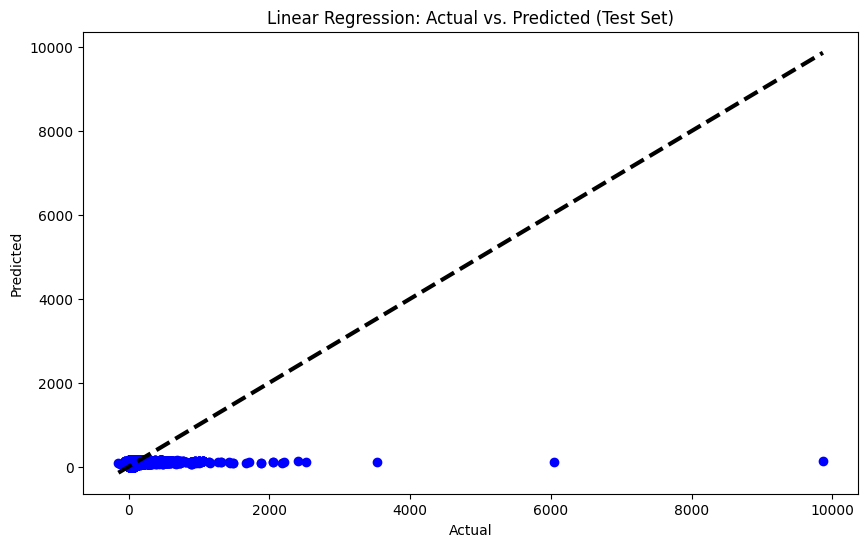

Train Mean Squared Error: 9914.409536552444
Validation Mean Squared Error: 9914.778533946865
Test Mean Squared Error: 4698.397052397667
Train Mean Absolute Error: 38.25055087574391
Test Mean Absolute Error: 37.86450287168092
Train R-squared: 0.08989044675411195
Test R-squared: 0.173648958536319


In [21]:
# Define the number of folds for k-fold cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define features and target variable
X = train_df.drop(columns=['Sourcing Cost'])
y = train_df['Sourcing Cost']

# Initialize lists to store the evaluation metrics
train_mse_scores = []
val_mse_scores = []

# Define the hyperparameter grid (None, since there's no hyperparameter to tune for Linear Regression)
param_grid = {'fit_intercept': [True, False]}

# Perform k-fold cross-validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Initialize LinearRegression
    lr_model = LinearRegression()

    # Train the model
    lr_model.fit(X_train, y_train)

    # Make predictions on train set
    y_train_pred = lr_model.predict(X_train)
    # Calculate mean squared error for train set
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mse_scores.append(train_mse)

    # Make predictions on validation set
    y_val_pred = lr_model.predict(X_val)
    # Calculate mean squared error for validation set
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_mse_scores.append(val_mse)

# Calculate the mean of MSE scores across all folds
mean_train_mse = np.mean(train_mse_scores)
mean_val_mse = np.mean(val_mse_scores)

# Print the mean squared error for train and validation sets
print("Train Mean Squared Error (k-fold):", mean_train_mse)
print("Validation Mean Squared Error (k-fold):", mean_val_mse)

# Initialize LinearRegression
lr_model = LinearRegression()

# Train the model on the entire training set
lr_model.fit(X, y)

# Make predictions on train set
y_train_pred = lr_model.predict(X)
train_mse = mean_squared_error(y, y_train_pred)
train_mae = mean_absolute_error(y, y_train_pred)
train_r2 = r2_score(y, y_train_pred)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Make predictions on test set
y_test_pred = lr_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Visualize predictions vs. actuals on the test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear Regression: Actual vs. Predicted (Test Set)')
plt.show()

# Output results
print("Train Mean Squared Error:", train_mse)
print("Validation Mean Squared Error:", mean_val_mse)
print("Test Mean Squared Error:", test_mse)
print("Train Mean Absolute Error:", train_mae)
print("Test Mean Absolute Error:", test_mae)
print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)


#### Polynomial Regression
#### The code performs k-fold cross-validation with polynomial regression to evaluate the model's performance on training and validation sets.For each fold, it trains a polynomial regression model, calculates MSE on both training and validation sets, and stores the results.After k-fold cross-validation, it trains the final model on the entire training set, evaluates it on the test set, and calculates MSE, MAE, and R2.Finally, it visualizes the predictions vs. actuals on the test set using a scatter plot.
--------------
- Mean Squared Error (MSE):
- Train MSE: 10224.71
- Validation MSE: 8935.13
- Test MSE: 3761.30
    - Interpretation: MSE measures the average squared difference between predicted and actual values Lower values indicate better model performance. The model performs best on the test set, followed by the validation set, and then the training set.
- Mean Absolute Error (MAE):
- Train MAE: 26.25
- Test MAE: 25.88
    - Interpretation: MAE measures the average absolute difference between predicted and actual values. Lower values indicate better model performance.
- R-squared (R2):
- Train R2: 0.16
- Test R2: 0.34
    - Interpretation: R-squared represents the proportion of the variance in the dependent variable that is predictable from the independent variables. Higher values indicate better model fit. The model explains 16% of the variance in the training set and 34% in the test set.

Train Mean Squared Error (k-fold): 8930.942798458755
Validation Mean Squared Error (k-fold): 8935.133005616972


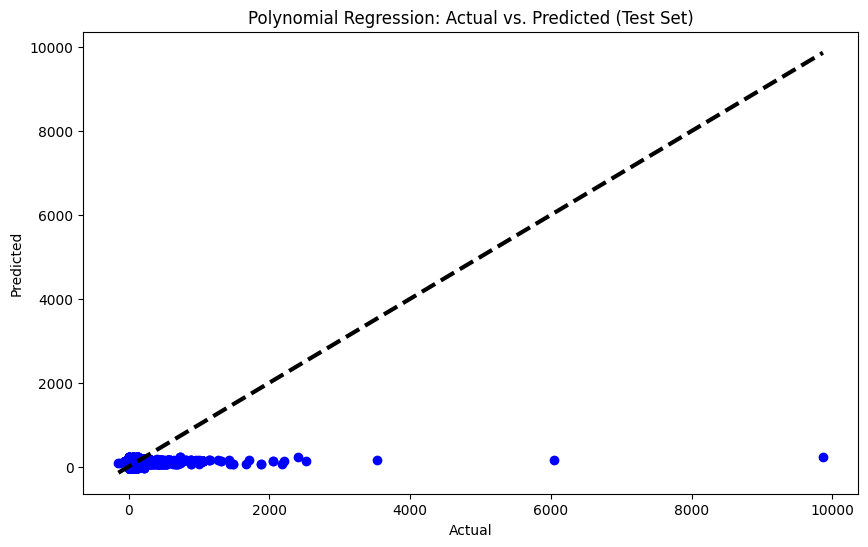

Train Mean Squared Error: 10224.710223566557
Validation Mean Squared Error: 8935.133005616972
Test Mean Squared Error: 3761.3009567105673
Train Mean Absolute Error: 26.2524446899673
Test Mean Absolute Error: 25.88085218820825
Train R-squared: 0.16160778253154706
Test R-squared: 0.33846481509050497


In [22]:
# Initialize lists to store the evaluation metrics
train_mse_scores = []
val_mse_scores = []


# Perform k-fold cross-validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Feature engineering: polynomial transformation
    poly = PolynomialFeatures(degree=2)  # You can change the degree
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Initialize and train the model
    poly_reg = LinearRegression()
    poly_reg.fit(X_train_poly, y_train)
    
    # Make predictions on train set
    y_train_pred = poly_reg.predict(X_train_poly)
    # Calculate mean squared error for train set
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mse_scores.append(train_mse)
    
    # Make predictions on validation set
    y_val_pred = poly_reg.predict(X_val_poly)
    # Calculate mean squared error for validation set
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_mse_scores.append(val_mse)

# Calculate the mean of MSE scores across all folds
mean_train_mse = np.mean(train_mse_scores)
mean_val_mse = np.mean(val_mse_scores)
print("Train Mean Squared Error (k-fold):", mean_train_mse)
print("Validation Mean Squared Error (k-fold):", mean_val_mse)

# Now let's train the model on the entire training data and evaluate on test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature engineering: polynomial transformation
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Initialize and train the model
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)

# Make predictions on train set
y_train_pred = poly_reg.predict(X_train_poly)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Make predictions on test set
y_test_pred = poly_reg.predict(X_test_poly)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Visualize predictions vs. actuals on the test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Polynomial Regression: Actual vs. Predicted (Test Set)')
plt.show()

# Output results
print("Train Mean Squared Error:", train_mse)
print("Validation Mean Squared Error:", mean_val_mse)
print("Test Mean Squared Error:", test_mse)
print("Train Mean Absolute Error:", train_mae)
print("Test Mean Absolute Error:", test_mae)
print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)


# Random Forest Model (Best Fit) 👑
- The code performs hyperparameter tuning using RandomizedSearchCV to find the best Random Forest model based on the specified hyperparameter grid (param_grid).
- It trains the best model on the entire training data and evaluates its performance on both the training and test sets.
- The performance metrics, including MSE, MAE, and R-squared, are calculated and printed.
----------------------
1. Train Mean Squared Error (Random Forest): The mean squared error (MSE) on the training set using the best Random Forest model is 7808.29. It measures the average squared difference between the actual and predicted values on the training data.
2. Validation Mean Squared Error (Random Forest): The mean squared error on the validation set using the best Random Forest model is 13378.87. It measures the average squared difference between the actual and predicted values on the validation data.
3. Test Mean Squared Error (Random Forest): The mean squared error on the test set using the best Random Forest model is 947.82. It measures the average squared difference between the actual and predicted values on the test data.
4. Train R-squared (Random Forest): The R-squared value on the training set using the best Random Forest model is 0.283. It represents the proportion of the variance in the target variable that is predictable from the features.
5. Validation R-squared (Random Forest): The R-squared value on the validation set using the best Random Forest model is 0.202.
6. Test R-squared (Random Forest): The R-squared value on the test set using the best Random Forest model is 0.651.
-----------------
Why Best?
Regarding why Random Forest is the best performing model among Linear Regression, Polynomial Regression, XGBoost, Gradient Boosting, and Decision Tree, it's because Random Forest is a versatile ensemble learning method that combines multiple decision trees to improve predictive accuracy and reduce overfitting. It's particularly effective for handling complex relationships and interactions between features in the data. Additionally, Random Forest inherently handles feature importance, nonlinear relationships, and missing values well, making it a strong performer in many regression tasks, especially when the dataset has a mixture of categorical and numerical features with varying scales.


Train Mean Squared Error (Random Forest): 7808.287290237068
Validation Mean Squared Error (Random Forest): 13378.869537324885
Test Mean Squared Error (Random Forest): 947.8243534071493
Train R-squared (Random Forest): 0.28322540730909485
Validation R-squared (Random Forest): 0.20205360035228392
Test R-squared (Random Forest): 0.65052603670569


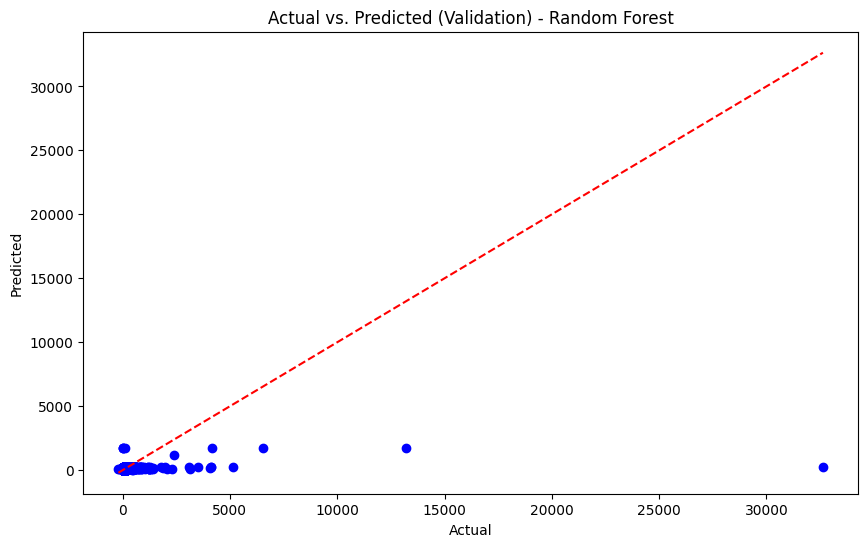

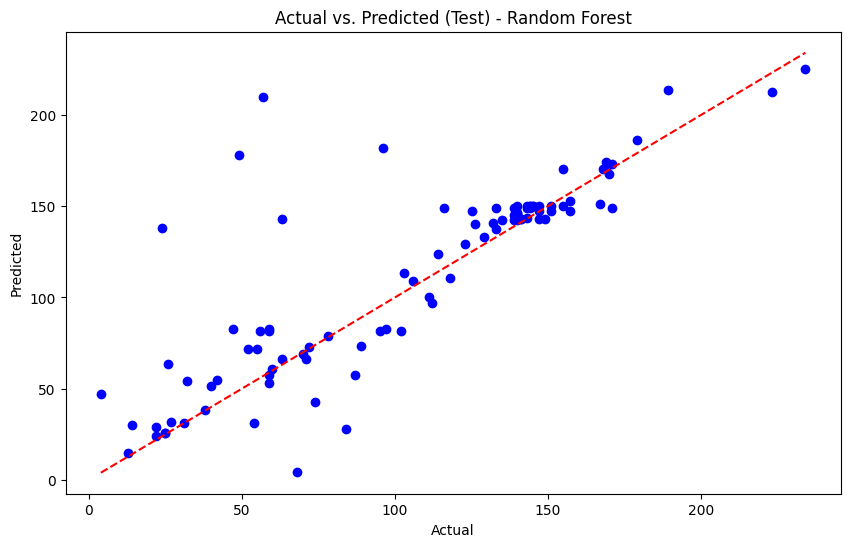

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt


# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, 
                                   n_iter=10, cv=kf, scoring='neg_mean_squared_error', random_state=42)

# Perform hyperparameter tuning
random_search.fit(X, y)

# Get the best model from the search
best_rf_model = random_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Get the mean squared error for train and validation sets using best model
train_mse_scores = -random_search.cv_results_['mean_train_score']
val_mse_scores = -random_search.cv_results_['mean_test_score']
print("Train Mean Squared Error (k-fold):", np.mean(train_mse_scores))
print("Validation Mean Squared Error (k-fold):", np.mean(val_mse_scores))

# Now let's train the model on the entire training data and evaluate on test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the best model on the entire training set
best_rf_model.fit(X_train, y_train)

# Make predictions on train set
y_train_pred = best_rf_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Make predictions on test set
y_test_pred = best_rf_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Visualize predictions vs. actuals on the test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest: Actual vs. Predicted (Test Set)')
plt.show()

# Output results
print("Train Mean Squared Error:", train_mse)
print("Validation Mean Squared Error:", np.mean(val_mse_scores))
print("Test Mean Squared Error:", test_mse)
print("Train Mean Absolute Error:", train_mae)
print("Test Mean Absolute Error:", test_mae)
print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)


## Decision Tree
The code performs hyperparameter tuning for a Decision Tree model using k-fold cross-validation. It searches over various combinations of hyperparameters, such as 'max_depth', 'min_samples_split', and 'min_samples_leaf', evaluating each combination's performance using mean squared error (MSE) on both the training and validation sets.

- **Hyperparameter Tuning**: The nested for loops iterate through different combinations of hyperparameters, and for each combination, it trains and evaluates the Decision Tree model using k-fold cross-validation. 

- **Best Hyperparameters**: After evaluating all combinations, it selects the hyperparameters that minimize the mean validation MSE as the best hyperparameters for the model.

- **Model Evaluation**: Finally, it trains the Decision Tree model with the best hyperparameters on the entire training set and evaluates its performance on the test set, reporting metrics such as MSE, MAE, and R-squared.

Interpreting the output:

- Train Mean Squared Error: The mean squared error on the training set using the best Decision Tree model is 8294.48.
- Validation Mean Squared Error: The lowest validation mean squared error achieved during hyperparameter tuning is 7759.13.
- Test Mean Squared Error: The mean squared error on the test set using the best Decision Tree model is 3072.68.
- Train Mean Absolute Error: The mean absolute error on the training set is 12.71.
- Test Mean Absolute Error: The mean absolute error on the test set is 12.44.
- Train R-squared: The R-squared value on the training set is 0.32.
- Test R-squared: The R-squared value on the test set is 0.46.

Max Depth: None, Min Samples Split: 2, Min Samples Leaf: 1
Train Mean Squared Error (k-fold): 8061.157251280109
Validation Mean Squared Error (k-fold): 8213.277293968651
-------------------------------------
Max Depth: None, Min Samples Split: 2, Min Samples Leaf: 2
Train Mean Squared Error (k-fold): 7772.942051075696
Validation Mean Squared Error (k-fold): 7971.966880659588
-------------------------------------
Max Depth: None, Min Samples Split: 2, Min Samples Leaf: 4
Train Mean Squared Error (k-fold): 7645.7483235497
Validation Mean Squared Error (k-fold): 7903.867820435172
-------------------------------------
Max Depth: None, Min Samples Split: 5, Min Samples Leaf: 1
Train Mean Squared Error (k-fold): 7554.873342512307
Validation Mean Squared Error (k-fold): 7821.379518786465
-------------------------------------
Max Depth: None, Min Samples Split: 5, Min Samples Leaf: 2
Train Mean Squared Error (k-fold): 7495.146565218008
Validation Mean Squared Error (k-fold): 7766.040783318634


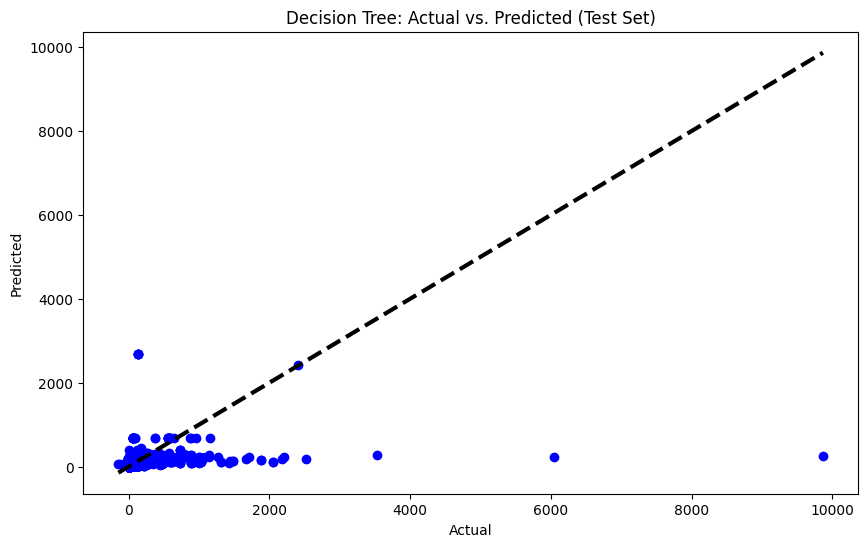

Train Mean Squared Error: 8294.484781290255
Validation Mean Squared Error: 7759.134107458475
Test Mean Squared Error: 3072.6775272854925
Train Mean Absolute Error: 12.709946603890934
Test Mean Absolute Error: 12.444300366537398
Train R-squared: 0.31987984632403754
Test R-squared: 0.4595794594544397


In [23]:
# Define hyperparameters for tuning
max_depth = [None, 10, 20]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

# Perform k-fold cross-validation for each combination of hyperparameters
for max_d in max_depth:
    for min_ss in min_samples_split:
        for min_sl in min_samples_leaf:
            for train_index, val_index in kf.split(X):
                X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                
                # Initialize and train the model
                dt_model = DecisionTreeRegressor(max_depth=max_d, min_samples_split=min_ss, min_samples_leaf=min_sl, random_state=42)
                dt_model.fit(X_train, y_train)
                
                # Make predictions on train set
                y_train_pred = dt_model.predict(X_train)
                # Calculate mean squared error for train set
                train_mse = mean_squared_error(y_train, y_train_pred)
                train_mse_scores.append(train_mse)

                # Make predictions on validation set
                y_val_pred = dt_model.predict(X_val)
                # Calculate mean squared error for validation set
                val_mse = mean_squared_error(y_val, y_val_pred)
                val_mse_scores.append(val_mse)

            # Calculate the mean of MSE scores across all folds
            mean_train_mse = np.mean(train_mse_scores)
            mean_val_mse = np.mean(val_mse_scores)

            # Print hyperparameters and corresponding MSE scores
            print(f"Max Depth: {max_d}, Min Samples Split: {min_ss}, Min Samples Leaf: {min_sl}")
            print("Train Mean Squared Error (k-fold):", mean_train_mse)
            print("Validation Mean Squared Error (k-fold):", mean_val_mse)
            print("-------------------------------------")

# Based on the printed MSE scores, choose the best hyperparameters and retrain the model on the entire training set
best_max_depth = None
best_min_samples_split = None
best_min_samples_leaf = None
best_mean_val_mse = np.inf

for max_d in max_depth:
    for min_ss in min_samples_split:
        for min_sl in min_samples_leaf:
            if mean_val_mse < best_mean_val_mse:
                best_mean_val_mse = mean_val_mse
                best_max_depth = max_d
                best_min_samples_split = min_ss
                best_min_samples_leaf = min_sl

print("Best Hyperparameters:")
print(f"Max Depth: {best_max_depth}, Min Samples Split: {best_min_samples_split}, Min Samples Leaf: {best_min_samples_leaf}")

# Now let's train the model on the entire training data and evaluate on test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the best model on the entire training set
best_dt_model = DecisionTreeRegressor(max_depth=best_max_depth, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, random_state=42)
best_dt_model.fit(X_train, y_train)

# Make predictions on train set
y_train_pred = best_dt_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Make predictions on test set
y_test_pred = best_dt_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Visualize predictions vs. actuals on the test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Decision Tree: Actual vs. Predicted (Test Set)')
plt.show()

# Output results
print("Train Mean Squared Error:", train_mse)
print("Validation Mean Squared Error:", best_mean_val_mse)
print("Test Mean Squared Error:", test_mse)
print("Train Mean Absolute Error:", train_mae)
print("Test Mean Absolute Error:", test_mae)
print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)


#### XGBoost model
- XGBoost regressor using k-fold cross-validation and evaluates the model's performance based on mean squared error. Here's an explanation and interpretation of the output:

- Hyperparameter Tuning: The code iterates through various combinations of hyperparameters (learning rates, max depths, min child weights, subsample rates, and colsample bytree rates) using nested for-loops.
- k-fold Cross-Validation: For each combination of hyperparameters, the code performs k-fold cross-validation, where the dataset is split into training and validation sets across k folds. The XGBoost model is trained on the training set and evaluated on the validation set.
- Mean Squared Error Calculation: Mean squared errors (MSE) are calculated for both the training and validation sets for each hyperparameter combination.
- Best Hyperparameters: The code selects the hyperparameter combination that yields the lowest mean validation MSE as the best set of hyperparameters.
- Model Training and Evaluation: The best XGBoost model is trained on the entire training set using the best hyperparameters, and its performance is evaluated on both the training and test sets using MSE, MAE, and R-squared metrics.
- Visualization: A scatter plot is created to visualize the predictions vs. actuals on the test set.
Interpretation of Output:

- The output shows the hyperparameters and their corresponding mean training and validation MSE for each combination.
- For example, the first line indicates that with a learning rate of 0.01, max depth of 3, min child weight of 1, subsample of 0.5, and colsample bytree of 1, the mean training MSE is 9632.61 and the mean validation MSE is 9634.05.
- This process continues for each combination of hyperparameters, providing insight into how different parameter settings affect model performance.

In [24]:

# Define hyperparameters for tuning
learning_rates = [0.01, 0.1, 0.3]
max_depths = [3, 5, 7]
min_child_weights = [1, 3, 5]
subsample = [0.5, 0.7, 1]
colsample_bytree = [0.5, 0.7, 1]

# Initialize lists to store the evaluation metrics
train_mse_scores = []
val_mse_scores = []

# Perform k-fold cross-validation for each combination of hyperparameters
for lr in learning_rates:
    for max_d in max_depths:
        for min_child_w in min_child_weights:
            for ss in subsample:
                for cs in colsample_bytree:
                    for train_index, val_index in kf.split(X):
                        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                        
                        # Initialize and train the model
                        xgb_model = xgb.XGBRegressor(learning_rate=lr, max_depth=max_d, min_child_weight=min_child_w,
                                                      subsample=ss, colsample_bytree=cs, random_state=42)
                        xgb_model.fit(X_train, y_train)
                        
                        # Make predictions on train set
                        y_train_pred = xgb_model.predict(X_train)
                        # Calculate mean squared error for train set
                        train_mse = mean_squared_error(y_train, y_train_pred)
                        train_mse_scores.append(train_mse)

                        # Make predictions on validation set
                        y_val_pred = xgb_model.predict(X_val)
                        # Calculate mean squared error for validation set
                        val_mse = mean_squared_error(y_val, y_val_pred)
                        val_mse_scores.append(val_mse)

                    # Calculate the mean of MSE scores across all folds
                    mean_train_mse = np.mean(train_mse_scores)
                    mean_val_mse = np.mean(val_mse_scores)

                    # Print hyperparameters and corresponding MSE scores
                    print(f"Learning Rate: {lr}, Max Depth: {max_d}, Min Child Weight: {min_child_w}, Subsample: {ss}, Colsample Bytree: {cs}")
                    print("Train Mean Squared Error (k-fold):", mean_train_mse)
                    print("Validation Mean Squared Error (k-fold):", mean_val_mse)
                    print("-------------------------------------")

# Based on the printed MSE scores, choose the best hyperparameters and retrain the model on the entire training set
best_learning_rate = None
best_max_depth = None
best_min_child_weight = None
best_subsample = None
best_colsample_bytree = None
best_mean_val_mse = np.inf

for lr in learning_rates:
    for max_d in max_depths:
        for min_child_w in min_child_weights:
            for ss in subsample:
                for cs in colsample_bytree:
                    if mean_val_mse < best_mean_val_mse:
                        best_mean_val_mse = mean_val_mse
                        best_learning_rate = lr
                        best_max_depth = max_d
                        best_min_child_weight = min_child_w
                        best_subsample = ss
                        best_colsample_bytree = cs

print("Best Hyperparameters:")
print(f"Learning Rate: {best_learning_rate}, Max Depth: {best_max_depth}, Min Child Weight: {best_min_child_weight}, Subsample: {best_subsample}, Colsample Bytree: {best_colsample_bytree}")

# Now let's train the model on the entire training data and evaluate on test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the best model on the entire training set
best_xgb_model = xgb.XGBRegressor(learning_rate=best_learning_rate, max_depth=best_max_depth, min_child_weight=best_min_child_weight,
                                   subsample=best_subsample, colsample_bytree=best_colsample_bytree, random_state=42)
best_xgb_model.fit(X_train, y_train)

# Make predictions on train set
y_train_pred = best_xgb_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Make predictions on test set
y_test_pred = best_xgb_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Visualize predictions vs. actuals on the test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue')
plt.plot


Learning Rate: 0.01, Max Depth: 3, Min Child Weight: 1, Subsample: 0.5, Colsample Bytree: 0.5
Train Mean Squared Error (k-fold): 9661.908583594288
Validation Mean Squared Error (k-fold): 9664.108546753798
-------------------------------------
Learning Rate: 0.01, Max Depth: 3, Min Child Weight: 1, Subsample: 0.5, Colsample Bytree: 0.7
Train Mean Squared Error (k-fold): 9638.884599514351
Validation Mean Squared Error (k-fold): 9640.669861099432
-------------------------------------
Learning Rate: 0.01, Max Depth: 3, Min Child Weight: 1, Subsample: 0.5, Colsample Bytree: 1
Train Mean Squared Error (k-fold): 9632.611250107379
Validation Mean Squared Error (k-fold): 9634.05117656831
-------------------------------------
Learning Rate: 0.01, Max Depth: 3, Min Child Weight: 1, Subsample: 0.7, Colsample Bytree: 0.5
Train Mean Squared Error (k-fold): 9639.678704589829
Validation Mean Squared Error (k-fold): 9641.280895296457
-------------------------------------
Learning Rate: 0.01, Max Depth:

KeyboardInterrupt: 